 # Homework 2 - eCommerce analytics

## Liabraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import gc

## Load Datasets

In [2]:
oct19= pd.read_csv('2019-Oct.csv',
                      parse_dates=['event_time'],
                      date_parser=pd.to_datetime)
nov19=pd.read_csv('2019-Nov.csv',
                      parse_dates=['event_time'],
                      date_parser=pd.to_datetime)

In [3]:
frame = [oct19,nov19]
df = pd.concat(frame)

## Before Starting
Before starting to solve questions, we should to see the datatype of each column of our dataset.

**Show the top 5 rows**

In [4]:
print(df.shape) 
df.head(5)

(109950743, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


**Show the bottom 5 rows**

In [5]:
df.tail(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
67501974,2019-11-30 23:59:58+00:00,view,15700137,2053013559733912211,NaN,NaN,277.74,532714000,02b4131c-0112-4231-aafa-ceaa08e77c1b
67501975,2019-11-30 23:59:58+00:00,view,28719425,2053013565639492569,apparel.shoes,baden,62.81,545223467,734c5eef-0742-4f8b-9d22-48f75b0bc359
67501976,2019-11-30 23:59:59+00:00,view,1004833,2053013555631882655,electronics.smartphone,samsung,167.03,557794415,6fecf566-ebb0-4e70-a243-cdc13ce044cb
67501977,2019-11-30 23:59:59+00:00,view,2701706,2053013563911439225,appliances.kitchen.refrigerators,samsung,566.27,531607492,368ddc8b-5db9-40fb-b7ff-b6582a1192c0
67501978,2019-11-30 23:59:59+00:00,view,1004233,2053013555631882655,electronics.smartphone,apple,1312.52,579969851,90aca71c-ed8a-4670-866a-761ebacb732d


## Q1 Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. Which is the rate of complete funnels?

For this problem, we should calculate all the rows that its event_type in a user_session equals to three,and this value（write as Th） is the total numbers of complete funnels. The total numbers of distinct user_session is written as Total. So the rate euqals to Th/Total.

In [6]:
CF =pd.DataFrame( df.groupby(['product_id','user_session','event_type']).event_type.count()).rename(columns={'event_type':'count'}).reset_index()
#rename()-> Alter axes labels.
#reset_index()->Reset the index of the DataFrame, and use the default one instead. 
CF = pd.DataFrame(CF.groupby(['product_id','user_session']).user_session.count()).rename(columns={'user_session':'count'}).reset_index()
Total= CF.shape[0]
Th = CF[CF['count']==3].shape[0]
CFR = round(Th*100 / Total,2)
print("The rate of complete funnels is "+str(CFR)+'%.')


The rate of complete funnels is 1.45%.


In [7]:
gc.collect()

20

### Q1-1 What's the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).

For this question, we calculate the total number of different operations and the total number of unique user sessions. Then we can calculate and compare the average number of times user perform each operation.

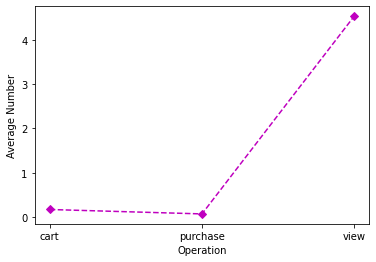

The most common operation:view


In [24]:
'''
Calculate all the times of diffenrent operations AP
'''
AP = df.groupby('event_type').event_type.count()
#print(AP)
# nunique()-> Return number of unique elements in the object.
# unique()-> Return the value of unique elements in the object.
'''
Calculate the average number of times users perform each operation AVAP
'''
AVAP = AP.to_numpy() / df.user_session.nunique()
#print(df.user_session.nunique())
'''
Sort the event_type by the number of  different operations ET
'''
ET = sorted(df.event_type.unique())
plt.xlabel('Operation')
plt.ylabel('Average Number')
plt.plot(ET, AVAP, color='m', linestyle='dashed',  marker='D')
plt.show()

print("The most common operation:"+str(ET[-1]))


In [9]:
gc.collect()

2045

### Q1-2 How many times, on average, a user views a product before adding it to the cart?

In [10]:

VCT= pd.DataFrame(df[(df.event_type == 'view') | (df.event_type == 'cart')].groupby(['product_id','user_session', 'event_type']).event_type.count()).rename(columns={'event_type':'my_count'}).reset_index()
VC = pd.DataFrame(VCT.groupby(['product_id','user_session']).user_session.count()).rename(columns={'user_session':'count'}).reset_index()
VC = VC[VC['count'] == 2]
VC = pd.merge(VCT,VC[['product_id','user_session']], how='inner', on=['product_id','user_session'])
MT= VCT[VCT['event_type'] == 'view'].my_count.mean()
print("The average times that users view a product before purchase is "+str(round(MT,2)))


The average times that users view a product before purchase is 1.5


In [11]:
gc.collect()

20

### Q1-3 What's the probability that products added once to the cart are effectively bought?

Let a={product is added once to the cart},b={product is purchased},then P(products added once to the cart are effectively bought)=P(b|a).
From the multiplication rule, we can know that P(ab)= P(b|a) * P(a), so P(b|a) = P(ab)/P(a).

In [12]:
P_a=df[df['event_type']=='cart'].shape[0]
#Sum = df.user_session.nunique()
CP = pd.DataFrame(df[(df.event_type == 'cart') | (df.event_type == 'purchase')].groupby(['product_id','user_session', 'event_type']).event_type.count()).rename(columns={'event_type':'my_count'}).reset_index()
CP = pd.DataFrame(CP.groupby(['product_id','user_session']).user_session.count()).rename(columns={'user_session':'count'}).reset_index()
CP = CP[CP['count']==2]
P_ab= CP.shape[0]
#P_ab = (Pa * P_b_a) / pow(Sum,2)
P_ba = round(P_ab / P_a,2) 
print("The probability that products added once to the cart are effectively bought is " + str(P_ba))

The probability that products added once to the cart are effectively bought is 0.26


In [13]:
gc.collect()

20

### Q1-4 What's the average time an item stays in the cart before being removed?

Because we do not find any removerfromcart operation in the file, we think that goods are removed from the cart means that they are purchased successfully.
The average time an item stays in the cart before being removed can be transform to the average time an item stays in the cart before purchased.

In [34]:
#DataFrame.drop_duplicates(subset=None, keep='first', inplace=False)
#pd.dropna()Filter out missing data
'''
pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
'''
#find all the cart/purchase operation and its event time, then keep the first occured repeat sessions and remove others
cart = df[df['event_type'] == 'cart'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
remove = df[df['event_type'] == 'purchase'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
#calculate the intersection of purchase and cart within a user session and delete the missing value 
#such as no cart operation or no purchase operation within a user session then it would be filtered out
result = pd.merge(cart, remove[['user_session','event_time']], how='inner', on=['user_session']).dropna()
#calculate the mean time between cart view and first purchase
mean_time = (result.event_time_y - result.event_time_x).mean()
cart_remove_time = pd.Timedelta(mean_time).total_seconds() 
print("The average time an item stays in the cart before being removed is " +str(round(cart_remove_time,2))+ ' seconds.')

The average time an item stays in the cart before being removed is 162.05 seconds.


In [15]:
gc.collect()

20

### Q1-5 How much time passes on average between the first view time and a purchase/addition to cart?

In [36]:
#find all the view/cart operation and its event time, then keep the first occured repeat sessions and remove others
view = df[df['event_type'] == 'view'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
cart = df[df['event_type'] == 'cart'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
#calculate the intersection of view and cart within a user session and delete the missing value 
#such as no cart operation or no view operation within a user session then it would be filtered out
result = pd.merge(view, cart[['user_session','event_time']], how='inner', on=['user_session']).dropna()
#calculate the mean time between first view and first cart
mean_time = (result.event_time_y - result.event_time_x).mean()
view_cart_time = pd.Timedelta(mean_time).total_seconds()
print("The average time between the first view and add to cart is " +str(round(view_cart_time,2))+ ' seconds.')

The average time between the first view and add to cart is 350.25 seconds.


In [37]:
#find all the view/purchase operation and its event time, then keep the first occured repeat sessions and remove others
view = df[df['event_type'] == 'view'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
purchase = df[df['event_type'] == 'purchase'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
#calculate the intersection of view and purchase within a user session and delete the missing value 
#such as no purchase operation or no view operation within a user session then it would be filtered out
result = pd.merge(view, purchase[['user_session','event_time']], how='inner', on=['user_session']).dropna()
#calculate the mean time between first view and first purchase 
mean_time = (result.event_time_y - result.event_time_x).mean()
view_purchase_time = pd.Timedelta(mean_time).total_seconds()
print("The average time between the first view and a purchase is " +str(round(view_purchase_time,2))+ ' seconds.')

The average time between the first view and a purchase is 422.75 seconds.


In [18]:
gc.collect()

40

## Q7 Prove that the pareto principle applies to your store.

The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers.

For prvove the Pareto principle, we just have to confirm that the head 20 percent of customers who have purchased goods in our store took up the 80 percent turnovers of our store.

In [31]:

#BC= pd.DataFrame(df[df.event_type == 'purchase'].groupby(['product_id','event_type','user_id']).user_id.count()).rename(columns={'user_id':'my_count'}).reset_index().groupby('my_count').my_count.count()
BCM = pd.DataFrame(df[df.event_type == 'purchase'].groupby(['user_id']).price.sum()).rename(columns={'price':'total_count'}).reset_index()
BCM = pd.DataFrame(BCM).sort_values(by=['total_count'],ascending=0)
customers_twper = math.ceil(0.2 * BCM.shape[0])
business = BCM.head(customers_twper).total_count.sum() / BCM.total_count.sum()
print("The head 20% custommers' purchasing power took up about "+str(round(business*100,2))+'% of the businesses.')

The head 20% custommers' purchasing power took up about 72.1% of the businesses.


From the result, we can see that about 72.1 percent of turnovers came from the head 20% of customers. Actually, the ration(2:7.21) is close to 2:8, so it shown that the Pareto principle states can be applied with the business in our store.